In [4]:
#Imports
import covasim as cv
from datetime import date, timedelta

Covasim 2.1.2 (2021-03-31) — © 2021 by IDM


In [5]:
## Date Extraction
today = date.today()

# Function to format date into proper string
def format_day(date):
    return date.strftime("%Y-%m-%d")

Initializing sim with 1000 people for 6 days
Initializing sim with 1000 people for 6 days
  Running "Baseline": 2021-04-03 ( 0/6) (0.09 s)  ••—————————————————— 14%
  Running "With beta changes": 2021-04-03 ( 0/6) (0.09 s)  ••—————————————————— 14%
Simulation "Baseline" summary:
     318 cumulative infections
      51 cumulative infectious
       0 cumulative tests
       0 cumulative diagnoses
       0 cumulative recoveries
      17 cumulative symptomatic cases
       0 cumulative severe cases
       0 cumulative critical cases
       0 cumulative deaths
       0 cumulative quarantined people

Simulation "With beta changes" summary:
     166 cumulative infections
      29 cumulative infectious
       0 cumulative tests
       0 cumulative diagnoses
       0 cumulative recoveries
      10 cumulative symptomatic cases
       0 cumulative severe cases
       0 cumulative critical cases
       0 cumulative deaths
       0 cumulative quarantined people



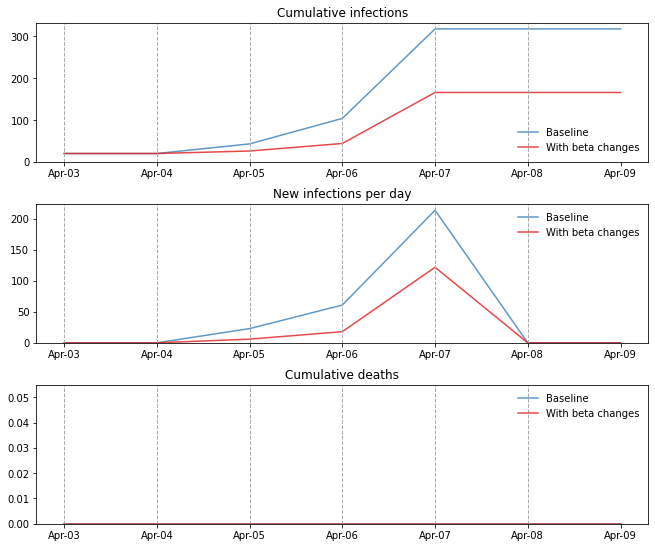

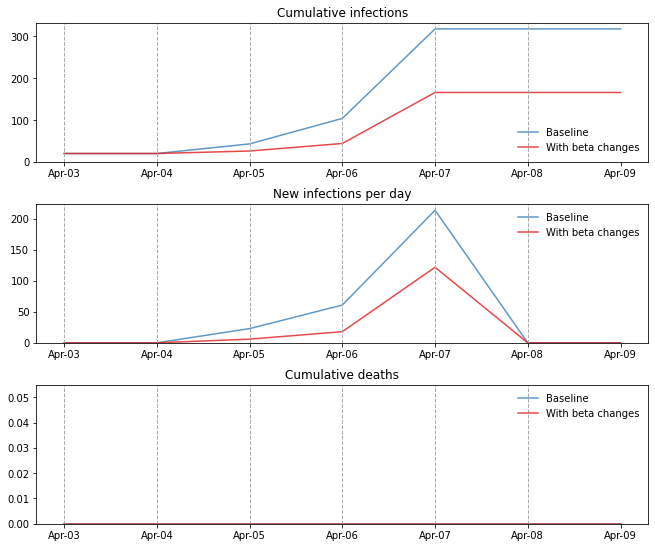

In [16]:
# Adjust model params here
event_length = 5 
baseline_beta = 6
mitigation_beta = 1.2
pop = 1000
# For time to death, should we just make it kill immediately by adjusting exp2inf and crit2die? Or add 30 days to simulation?

# Get start and end date of event, starting today
d1 = format_day(today)
d2 = format_day(today + timedelta(days = event_length + 1))

pars = dict(
    start_day = d1,
    end_day   = d2,
    pop_type  = 'hybrid',
    pop_size = pop
)

# Baseline event transmissibility
event = cv.dynamic_pars(beta=dict(days=list(range(event_length+1)), vals=[baseline_beta]*(event_length) + [0]))
orig_sim = cv.Sim(pars, interventions=event, label='Baseline')

# Mitigation event transmissibility
event_mitigate = cv.dynamic_pars(beta=dict(days=list(range(event_length+1)), vals=[mitigation_beta]*(event_length) + [0]))
sim = cv.Sim(pars, interventions=event_mitigate, label='With beta changes')

# Run and plot
msim = cv.MultiSim([orig_sim, sim])
msim.run()
msim.plot()

